In [1]:
# Install packages where necessary.
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-ibm-runtime
!pip install qiskit-aer
!pip install qiskit-algorithms

  Using cached qiskit-1.1.1-cp38-abi3-win_amd64.whl.metadata (13 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.2.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.11.0-cp311-cp311-win_amd64.whl.metadata (1.2 kB)
  Using cached pbr-6.0.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached qiskit-1.1.1-cp38-abi3-win_amd64.whl (4.1 MB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 660.6 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.8 MB 1.1 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/1.8 MB 1.3 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.8 MB 1.6 MB/s eta 0:00:01
   ------- -------------------------------- 0.4/1.8 MB 1.6 MB/s eta 0:00:01
   ------- -------------------------------- 0.4/1.8 MB 1.6 MB/s eta 0:00:01
   ------------ -------------

In [16]:
# Imports, as always...
from os import makedirs, path
import numpy as np
import pandas as pd
from qiskit_algorithms.utils import algorithm_globals
from typing import List
import warnings
from datetime import date

# Circuitry.
from qiskit import qpy
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, ParameterVector
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import random_unitary, random_statevector

# Runtime.
from qiskit import transpile
from qiskit_ibm_runtime.fake_provider import FakeAthensV2
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # This is a more flexible method for transpiling.

# Plotting.
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Styling.
sns.set_context('paper')
sns.set_theme(style='darkgrid', palette='Dark2')

# Version control.
from qiskit import __version__ as qiskit_version
from qiskit_ibm_runtime import __version__ as runtime_version

# RNG.
def reset_seed(seed):
  if seed is None:
    return

  np.random.seed(seed)
  algorithm_globals.random_seed = seed

# Runtime service. NOT TO BE EXPOSED PUBLICLY.
service = QiskitRuntimeService(channel='ibm_quantum', token='90f74dbca51821d1203799d5afc2a9c70b836eb1a6377e53367bb9896ec9e7faa9678a9981ad6bf6bf44dd5accb83ee576a3e6eb8d85249f7d98a138f2d8a5f1')

# Data save path.
data_save_path = './data/fake-backend'
makedirs(data_save_path, exist_ok=True)

# Ignore warnings.
warnings.filterwarnings('ignore')

# Important package versions.
print('Important Package Versions...\n')
versions = [('qiskit', qiskit_version), ('qiskit-ibm-runtime', runtime_version), ('numpy', np.__version__)]

pad = max([len(x) for x, _ in versions])
for package, version in versions:
    print(f'{package:<{pad}} : {version}')

Important Package Versions...

qiskit             : 1.1.1
qiskit-ibm-runtime : 0.25.0
numpy              : 1.26.4


# Generating a Circuit

We use a **brickwork architecture** of parameterised width $n$ and depth $d$, which consists of $d$ layers of interlocking two-qubit gates drawn independently from the Haar measure on $\mathbb{U}(4)$. The idea is to generate a circuit without bias towards any particular qubits, becoming closer and closer to a circuit producing a completely uniform probability distribution over the possible output states as $d$ increases.

In [3]:
# Function to generate a circuit using the brickwork architecture.
def generate_brickwork_circuit(n : int, d : int, seed = None):
  # A brickwork circuit only really makes sense with at least 3 qubits.
  assert n > 2, 'Brickwork architectures require at least 3 qubits to be worth the bother.'

  # RNG.
  reset_seed(seed)

  # Instantiate the circuit object.
  circuit = QuantumCircuit(n)

  for l in range(d):
    # Even layer arangement.
    if l % 2 == 0:
      # Loop over the qubits onto to which the 'bricks' will be 'layed'.
      for i in range(n // 2):
        # Add a Haar random unitary from U(4).
        circuit.append(
            UnitaryGate(random_unitary(4), label='$U_{' + str(l) + str(i) + '}$'),
            [2*i, 2*i + 1]
        )

    # Odd layer arangement is offset by one qubit.
    else:
      # Looping again.
      for i in range(1, n // 2 + 1):
        # Add again.
        circuit.append(
            UnitaryGate(random_unitary(4), label='$U_{' + str(l) + str(i) + '}$'),
            [2*i - 1, 2*i]
        )

  return circuit

# Demo.
circuit = generate_brickwork_circuit(n=5, d=4)
circuit.draw()

┌───────────┐             ┌───────────┐             
q_0: ┤0          ├─────────────┤0          ├─────────────
     │  $U_{00}$ │┌───────────┐│  $U_{20}$ │┌───────────┐
q_1: ┤1          ├┤0          ├┤1          ├┤0          ├
     ├───────────┤│  $U_{11}$ │├───────────┤│  $U_{31}$ │
q_2: ┤0          ├┤1          ├┤0          ├┤1          ├
     │  $U_{01}$ │├───────────┤│  $U_{21}$ │├───────────┤
q_3: ┤1          ├┤0          ├┤1          ├┤0          ├
     └───────────┘│  $U_{12}$ │└───────────┘│  $U_{32}$ │
q_4: ─────────────┤1          ├─────────────┤1          ├
                  └───────────┘             └───────────┘

## Variable Input

We would like to support variable inputs (because why not). To do this, we can either pass a random state vector into an initialisation method, or we can add some parameterised gates to the circuit to control the input state according to a set of parameters. The latter feels more sensible, and may well be easier to work with downstream when we want to run circuits multiple times (e.g. without having to redefine a circuit with a new preparation). Whether there is any tangible difference between the two is not known to us (because we haven't checked).

In [4]:
def generate_parameterised_input_layer(n : int):
  # Instantiate a circuit.
  circuit = QuantumCircuit(n)

  input_parameters = ParameterVector(name='in', length=n)
  for i in range(n):
    circuit.rx(np.pi * input_parameters[i], i)

  return circuit

# Demo.
circuit = generate_parameterised_input_layer(n=5)
circuit.draw()

┌─────────────┐
q_0: ┤ Rx(π*in[0]) ├
     ├─────────────┤
q_1: ┤ Rx(π*in[1]) ├
     ├─────────────┤
q_2: ┤ Rx(π*in[2]) ├
     ├─────────────┤
q_3: ┤ Rx(π*in[3]) ├
     ├─────────────┤
q_4: ┤ Rx(π*in[4]) ├
     └─────────────┘

# Executing Circuits

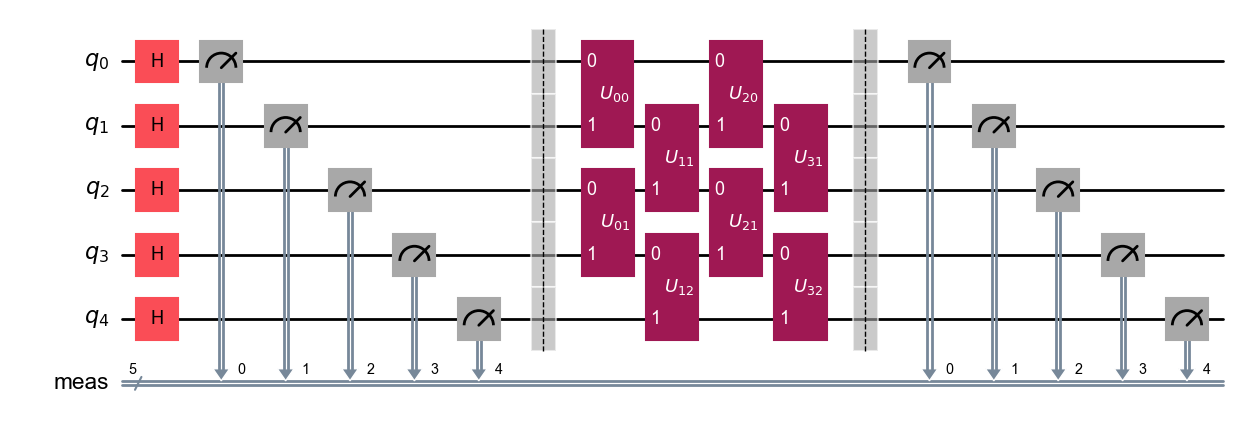

In [6]:
def build_experiment_circuit(n : int, d : int, brickwork_circuit = None, parameterised : bool = False, seed = None):
  # Quanutm circuit.
  q_reg = QuantumRegister(n, name='q')
  c_reg = ClassicalRegister(n, name='meas')

  # Circuit object.
  circuit = QuantumCircuit(q_reg, c_reg)

  # Preparation layer.
  if parameterised:
    circuit.compose(generate_parameterised_input_layer(n), inplace=True)
  else:
    circuit.h(range(n))
    circuit.measure(q_reg, c_reg)

  circuit.barrier()

  # Brickwork layer.
  if brickwork_circuit is None:
    circuit.compose(generate_brickwork_circuit(n, d, seed=seed), inplace=True)
  else:
    circuit.compose(brickwork_circuit, inplace=True)

  circuit.barrier()

  # Measurement layer.
  circuit.measure(q_reg, c_reg)

  return circuit

# Demo.
circuit = build_experiment_circuit(n=5, d=4, seed=42, parameterised=False)
circuit.draw('mpl', style='iqp', vertical_compression='high', fold=-1)

Local simulators were retired in May 2024, very annoyingly. As an alternative, we'll be using a "fake backend" here (rather than e.g. Qiskit Aer) so that we can locally test with a noise model taken from a system snapshot. When we're happy with how we are generating data, we can take it to real hardware.

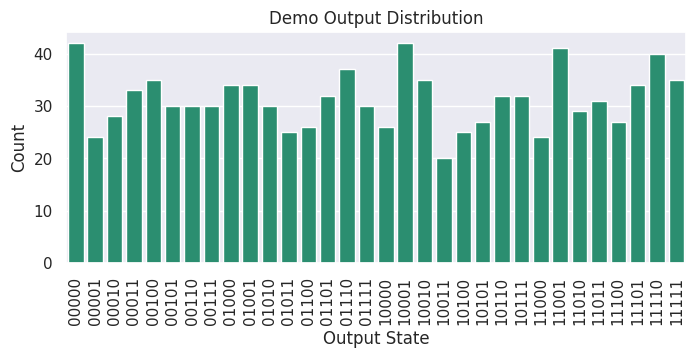

In [ ]:
# Backend.
fake_athens = FakeAthensV2()

# Transpile.
transpiled_circuit = transpile(circuit, backend=fake_athens)

# Run (by sampler).
sampler = Sampler(mode=fake_athens)
job = sampler.run([(transpiled_circuit, None, 1000)])

# Into counts.
counts = job.result()[0].data.meas.get_counts()
counts = dict(sorted(counts.items()))

# Plot.
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sns.barplot(x=counts.keys(), y=counts.values(), ax=ax)

# Beautification.
ax.set_title('Demo Output Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Output State')
ax.tick_params(axis='x', labelrotation=90)

## Data in Measurement Steps

"Measurement step" data are data generated by the same circuit at different points in time, hopefully capturing a sense of 'age' for the noise fingerprint that may preclude the operations being run.

The difficulty here is that *we do not have custody of the device*, so we cannot know what happens to the qubits or the device itself between calls. What can we say about the character of the noise fingerprint between calls if we do not know what happens in that interim, or how long the gap between calls actually is? Well... we can't really...

We will be exploting the collapsing nature of measurements in quantum mechanics to "re-prepare" the circuit at runtime. This will allow us to make a single call to the hardware service to perform multiple "measurement steps" (as they are called in Martina et al. 2021), thus giving us comfort about the existence of the qubit while we are working on them.


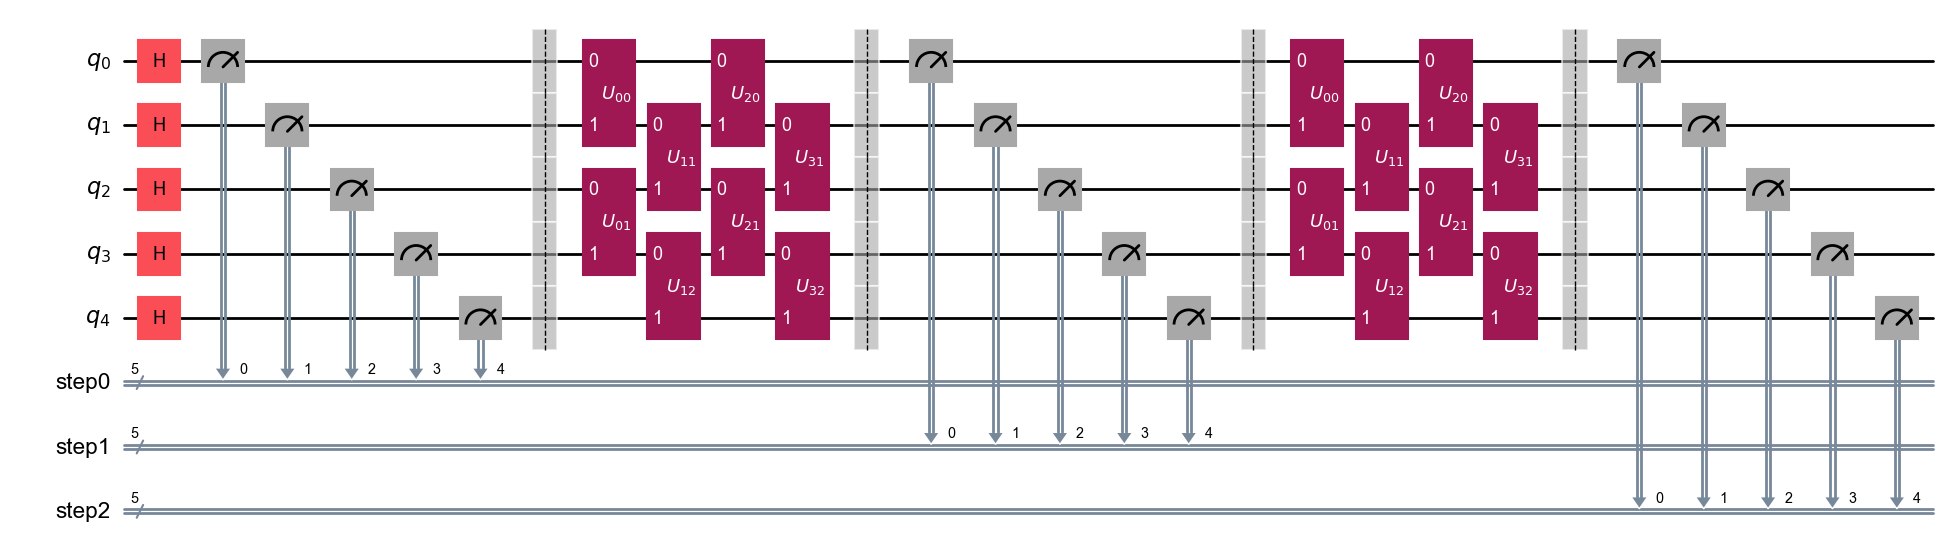

In [7]:
def build_chained_circuit(brickwork_circuit : QuantumCircuit, k : int, parameterised_input : bool = False):
  assert k > 1, 'Number of measurement steps (k) must be a positive integer.'

  # Quanutm circuit.
  n = brickwork_circuit.num_qubits
  q_reg = QuantumRegister(n, name='q')
  c_regs = [ClassicalRegister(n, name=f'step{i}') for i in range(k + 1)]

  # Circuit object.
  circuit = QuantumCircuit(*([q_reg] + c_regs))

  # Set up an input layer.
  if parameterised_input:
    input_layer = generate_parameterised_input_layer(n)
    circuit.compose(input_layer, inplace=True)
  else:
    circuit.h(range(n))
    circuit.measure(q_reg, c_regs[0])

  # Alternate between brickwork and measurement for k steps.
  for i in range(1, k + 1):
    circuit.barrier()
    circuit.compose(brickwork_circuit, inplace=True)
    circuit.barrier()
    circuit.measure(q_reg, c_regs[i])

  return circuit

# Demo.
brickwork_circuit = generate_brickwork_circuit(n=5, d=4)
chained_circuit = build_chained_circuit(brickwork_circuit, k=2)
chained_circuit.draw('mpl', style='iqp', vertical_compression='high', fold=-1)

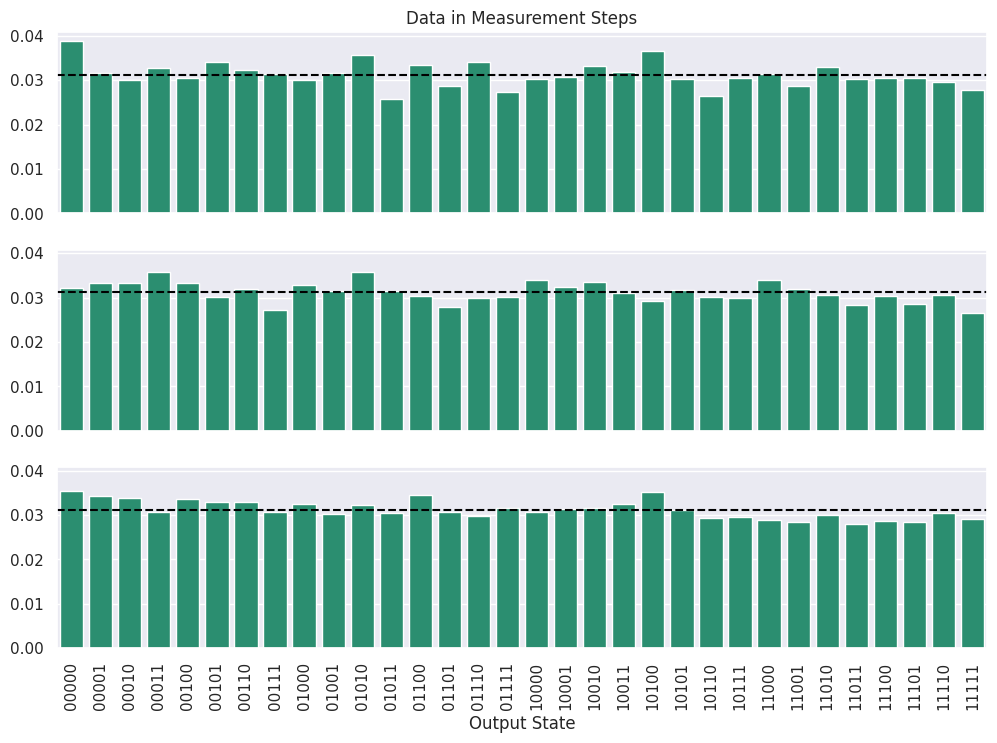

In [ ]:
# Backend.
fake_athens = FakeAthensV2()

# Transpile.
transpiled_circuit = transpile(chained_circuit, backend=fake_athens)

# Run (by sampler).
sampler = Sampler(mode=fake_athens)
#x = np.random.randint(2, size=(circuit.num_qubits,))
n_shots = 10000
job = sampler.run([(transpiled_circuit, None, n_shots)])

# Plot both steps.
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex='col', sharey='all')
for i in range(3):
  # Into counts.
  counts = job.result()[0].data[f'step{i}'].get_counts()
  counts = dict(sorted(counts.items()))

  # And then into probabilities.
  probs = {key: value / n_shots for key, value in counts.items()}

  # Plot.
  sns.barplot(x=probs.keys(), y=probs.values(), ax=axes[i])
  axes[i].axhline(1 / (2 ** circuit.num_qubits), color='k', linestyle='--')

# Beautification.
axes[0].set_title('Data in Measurement Steps')
axes[2].set_xlabel('Output State')
axes[2].tick_params(axis='x', labelrotation=90)

# Data in Depth-varied Circuits

Maybe it would be best to avoid multiple measurements so that we don't 'filter out' any noise that may have accumulated up to that point. However, if we only measure a circuit once, then how can we collect any information with respect to *time*?

As an alternative to measurement step data, we can produce distributions at different depths of brickwork circuit, thereby allowing us to understand noise fingerprints that have 'persisted' for different numbers of operation (and thus time).

Some minimum depth should always be reached so that the outcome distribution is expected to be sufficiently uniform. This reveals our intentions behind the choice of the brickwork architecture, whose character is to do exactly this in the limit of depth.

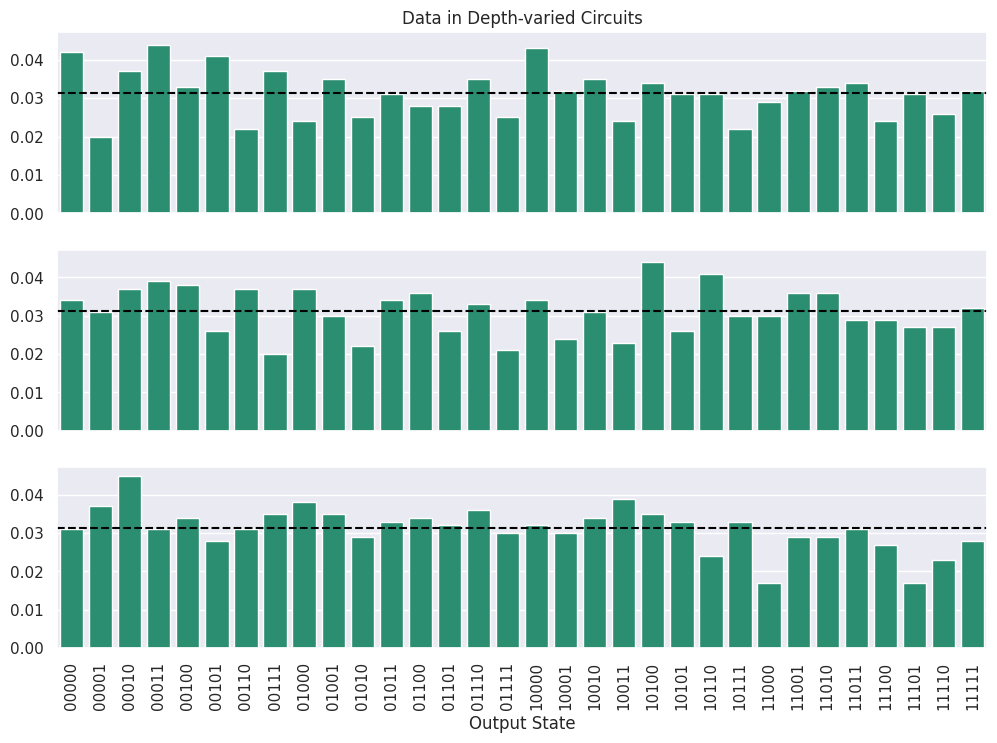

In [ ]:
# Define circuits of varying depth.
ds = [5, 10, 15]
circuits = [build_experiment_circuit(n=5, d=d) for d in ds]

# Backend.
fake_athens = FakeAthensV2()

# Transpile.
transpiled_circuits = [transpile(circuit, backend=fake_athens) for circuit in circuits]

# Run (by sampler).
sampler = Sampler(mode=fake_athens)
n_shots = 1000
job = sampler.run([(transpiled_circuit, None, n_shots) for transpiled_circuit in transpiled_circuits])

# Plot for all depths.
fig, axes = plt.subplots(len(ds), 1, figsize=(4 * len(ds), 8), sharex='col', sharey='all')
for i, d in enumerate(ds):
  # Into counts.
  counts = job.result()[i].data.meas.get_counts()
  counts = dict(sorted(counts.items()))

  # And then into probabilities.
  probs = {key: value / n_shots for key, value in counts.items()}

  # Plot.
  sns.barplot(x=probs.keys(), y=probs.values(), ax=axes[i])
  axes[i].axhline(1 / (2 ** circuit.num_qubits), color='k', linestyle='--')

# Beautification.
axes[0].set_title('Data in Depth-varied Circuits')
axes[-1].set_xlabel('Output State')
axes[-1].tick_params(axis='x', labelrotation=90)

# Data in Identity Circuits

Producing data with variable-depth brickwork circuits solves the issue of measuring multiple times, but it introduces a new problem: now we aren't doing the same thing to the qubits at different depths (and thus different "time steps" have different outcomes, albeit outcomes we expect to be the same in the limit).

So, an alternative to the two previous methods is to use a circuit that, at any depth, will always produce the same output. Not a deterministic circuit, but one whose outcome distribution is invariant to depth *for every case*. We can do this by using the same brickwork *twice* -- once to perform the circuit, and a second time to invert it (i.e. apply it backwards), making the overall action simply the identity! Of course, it is not an indentity because things are certainly happening to the qubits, so noise will happen all the same.

A wonderful bonus for this method is that we can measure how much noise has happened by simply looking at the difference between the distribution of states going in and the distribution of states coming out! Cheap and easy.

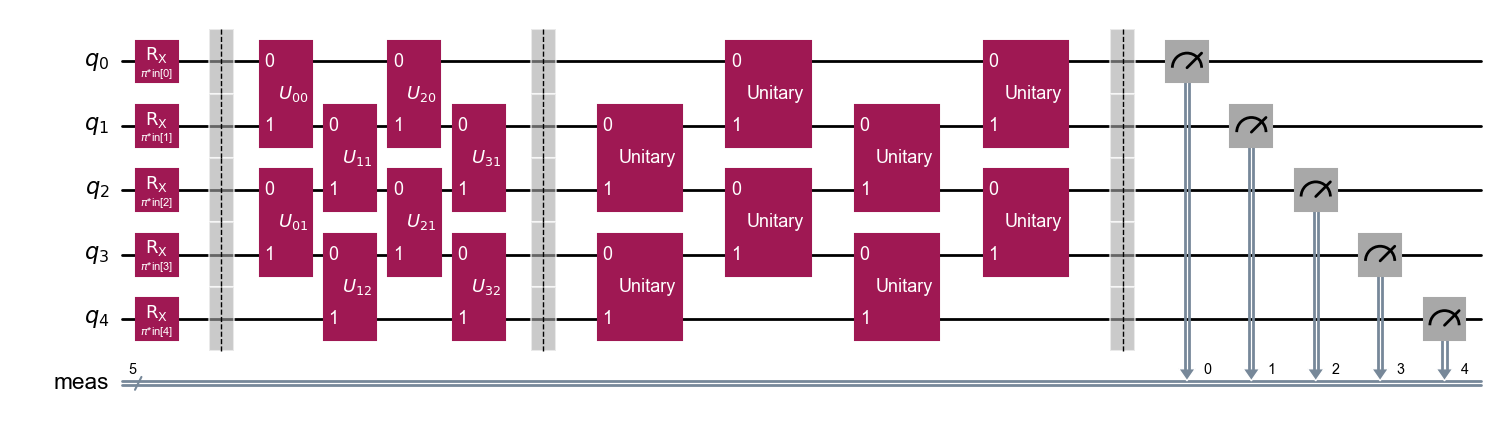

In [8]:
def build_identity_circuit(n : int, d : int, seed = None, parameterised : bool = False):
  # Quanutm circuit.
  q_reg = QuantumRegister(n, name='q')
  c_reg = ClassicalRegister(n, name='meas')

  # Circuit object.
  circuit = QuantumCircuit(q_reg, c_reg)

  # Prepare the input.
  if parameterised:
    circuit.compose(generate_parameterised_input_layer(n), inplace=True)
  else:
    circuit.h(range(n))
    circuit.measure(q_reg, c_reg)

  circuit.barrier()

  # Add a brickwork circuit.
  brickwork_circuit = generate_brickwork_circuit(n, d, seed=seed)
  circuit.compose(brickwork_circuit, inplace=True)

  circuit.barrier()

  # Add it's inverse.
  circuit.compose(brickwork_circuit.inverse(), inplace=True)

  circuit.barrier()

  # Measure.
  circuit.measure(q_reg, c_reg)

  return circuit

# Demo
identity_circuit = build_identity_circuit(n=5, d=4, parameterised=True)
identity_circuit.draw('mpl', style='iqp', vertical_compression='high', fold=-1)

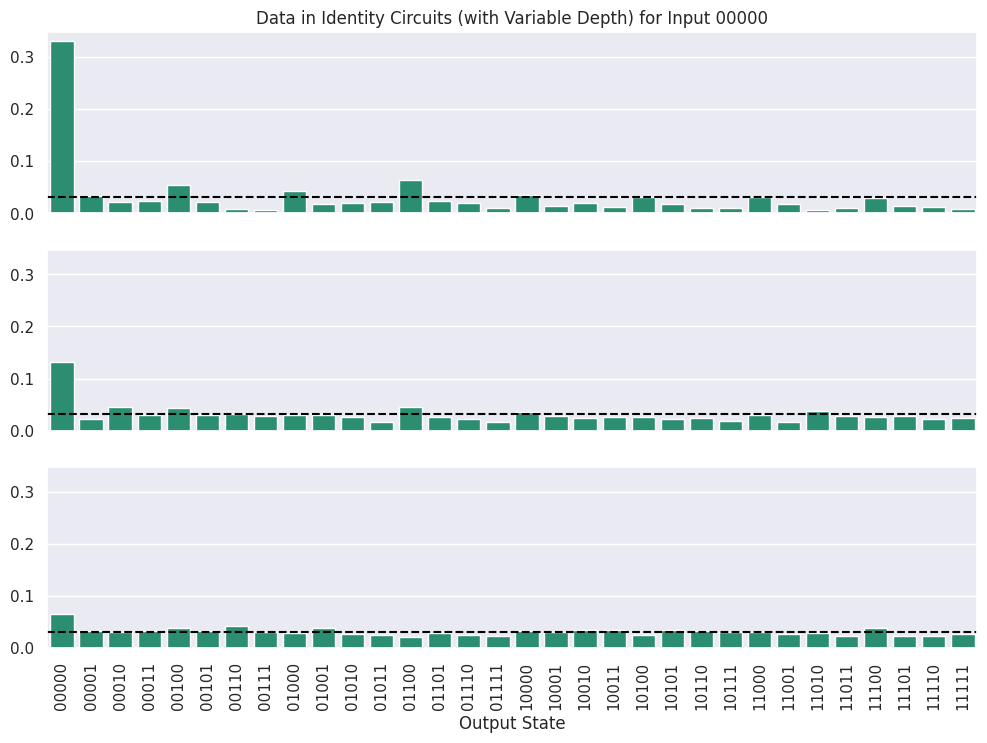

In [ ]:
# Define circuits of varying depth.
ds = [5, 10, 15]
circuits = [build_identity_circuit(n=5, d=d, parameterised=True) for d in ds]

# Backend.
fake_athens = FakeAthensV2()

# Transpile.
transpiled_circuits = [transpile(circuit, backend=fake_athens) for circuit in circuits]

# Run (by sampler).
sampler = Sampler(mode=fake_athens)
n_shots = 1000
x_in = np.zeros(5)
job = sampler.run([(transpiled_circuit, x_in, n_shots) for transpiled_circuit in transpiled_circuits])

# Plot for all depths.
fig, axes = plt.subplots(len(ds), 1, figsize=(4 * len(ds), 8), sharex='col', sharey='all')
for i, d in enumerate(ds):
  # Into counts.
  counts = job.result()[i].data.meas.get_counts()
  counts = dict(sorted(counts.items()))

  # And then into probabilities.
  probs = {key: value / n_shots for key, value in counts.items()}

  # Plot.
  sns.barplot(x=probs.keys(), y=probs.values(), ax=axes[i])
  axes[i].axhline(1 / (2 ** circuit.num_qubits), color='k', linestyle='--')

# Beautification.
axes[0].set_title('Data in Identity Circuits (with Variable Depth) for Input ' + ''.join(x_in.astype(int).astype(str)))
axes[-1].set_xlabel('Output State')
axes[-1].tick_params(axis='x', labelrotation=90)

# Data Generating Routine

Since we haven't decided on a method, we'll have to be pragmatic in defining a data generation routine based on each.

Some terminology:
- "**Measurement/time step**" $=$ (measurement of) a noise fingerprint for a particular time. In sequential methods (e.g. measurement-based), this correlates to the order in the sequence that the (measurement of the) noise fingerprint was taken in. In single-step methods (e.g. depth-varied), this correlates to the number of operations or duration before the (measurement of the) noise fingerprint was taken.
- "**Shot**" $=$ a single execution of the full circuit by a device. This will produce single bit-string outcomes at any measurement steps.
- "**Run**" $=$ the repetition of several shots, using the same parameters (if given). This will produce counts for each possible bit-string outcome obtained at any measurement steps, which we almost all convert into a probability distribution over these outcomes.
- "**Routine**" $=$ the co-ordinated execution of many runs over a set of parameters (if necessary) to produce a suite of noise fingerprints for a given device.

In [19]:
def measurement_step_routine(brickwork_circuit : QuantumCircuit, backend, k : int, n_runs : int, n_shots : int = 1000, write_to_file : bool = False) -> pd.DataFrame:
  # Chained circuit.
  chained_circuit = build_chained_circuit(brickwork_circuit, k, parameterised_input=False)

  # Infer circuit configuration.
  n, d = brickwork_circuit.num_qubits, brickwork_circuit.depth()

  # Transpile.
  transpiled_circuit = transpile(chained_circuit, backend=backend)

  # Sampler.
  sampler = Sampler(mode=backend)

  # Dataframe to hold results.
  results_df = pd.DataFrame(columns=['n', 'd', 'step', 'k', 'run', 'n_shots', 'device'] + [format(i, f'0{n}b') for i in range(2 ** n)])
  
  if write_to_file:
    # File name.
    file_path = path.join(data_save_path, date.today().strftime('measurement-step-(%Y-%m-%d-%H-%M-%S).csv'))
      
    # Empty file.
    results_df.to_csv(file_path, index=False, header=True)

  for run in range(1, n_runs + 1):
    # Run (via the sampler).
    job = sampler.run([(transpiled_circuit, None, n_shots)])

    # Convert into outcome distributions for each measurement step.
    outcomes = {
      step : {
        key: value / n_shots
        for key, value in job.result()[0].data[f'step{step}'].get_counts().items()
      } for step in range(k + 1)
    }

    # Compact into a DataFrame object.
    for step, outcome_distribution in outcomes.items():
      run_result_df = pd.DataFrame(columns=['n', 'd', 'step', 'k', 'run', 'n_shots', 'device'] + [format(i, f'0{n}b') for i in range(2 ** n)])

      # Translate the entries of the outcome distribution into the DataFrame.
      # Any outcome states not measured will be left as NaN in this DataFrame.
      for state, prob in outcome_distribution.items():
        run_result_df[state] = [prob]

      # "Meta" data.
      run_result_df['n'] = [n]
      run_result_df['d'] = [d]
      run_result_df['step'] = [step]
      run_result_df['k'] = [k]
      run_result_df['run'] = [run]
      run_result_df['n_shots'] = [n_shots]
      run_result_df['device'] = [backend.backend_name]

      # Add to the overall results.
      results_df = pd.concat([results_df, run_result_df], ignore_index=True)
          
      # Write to file.
      if write_to_file:
        run_result_df.to_csv(file_path, mode='a', index=False, header=False)

  return results_df

# Demo.
brickwork_circuit = generate_brickwork_circuit(n=3, d=5)
fake_athens = FakeAthensV2()
measurement_step_routine(brickwork_circuit, fake_athens, k=5, n_runs=2, n_shots=1000)

,n,d,step,k,run,n_shots,device,000,001,010,011,100,101,110,111
0,3,5,0,5,1,1000,fake_athens,0.132,0.125,0.132,0.102,0.122,0.137,0.125,0.125
1,3,5,1,5,1,1000,fake_athens,0.130,0.131,0.126,0.129,0.129,0.113,0.136,0.106
2,3,5,2,5,1,1000,fake_athens,0.139,0.133,0.124,0.106,0.114,0.118,0.135,0.131
3,3,5,3,5,1,1000,fake_athens,0.126,0.119,0.128,0.113,0.130,0.114,0.143,0.127
4,3,5,4,5,1,1000,fake_athens,0.116,0.121,0.131,0.127,0.115,0.132,0.117,0.141
5,3,5,5,5,1,1000,fake_athens,0.148,0.131,0.136,0.111,0.111,0.120,0.124,0.119
6,3,5,0,5,2,1000,fake_athens,0.133,0.121,0.128,0.127,0.107,0.128,0.113,0.143
7,3,5,1,5,2,1000,fake_athens,0.145,0.119,0.130,0.125,0.129,0.110,0.124,0.118
8,3,5,2,5,2,1000,fake_athens,0.134,0.105,0.124,0.145,0.127,0.124,0.106,0.135
9,3,5,3,5,2,1000,fake_athens,0.131,0.143,0.104,0.123,0.131,0.117,0.126,0.125


In [10]:
def depth_varied_routine(n : int, ds : List[int], backend, n_runs : int, n_shots : int = 1000) -> pd.DataFrame:
  # Dataframe to hold results.
  results_df = pd.DataFrame(columns=['n', 'd', 'run', 'n_shots', 'device'] + [format(i, f'0{n}b') for i in range(2 ** n)])

  for d in ds:
    # Build the depth-d brickwork circuit.
    brickwork_circuit = generate_brickwork_circuit(n, d)

    # Build the full circuit.
    experiment_circuit = build_experiment_circuit(n, d, brickwork_circuit)

    # Transpile.
    transpiled_circuit = transpile(experiment_circuit, backend=backend)

    # Sampler.
    sampler = Sampler(mode=backend)

    for run in range(1, n_runs + 1):
      # Run (via the sampler).
      job = sampler.run([(transpiled_circuit, None, n_shots)])

      # Convert into an outcome distribution.
      outcomes = {
          key: value / n_shots
          for key, value in job.result()[0].data.meas.get_counts().items()
      }

      # Compact into a DataFrame object.
      run_result_df = pd.DataFrame(columns=['n', 'd', 'run', 'n_shots', 'device'] + [format(i, f'0{n}b') for i in range(2 ** n)])

      # Translate the entires of the outcome distribution into the DataFrame.
      # Any outcome states not measured will be left as NaN in this DataFrame.
      for state, prob in outcomes.items():
        run_result_df[state] = [prob]

      # "Meta" data.
      run_result_df['n'] = [n]
      run_result_df['d'] = [d]
      run_result_df['run'] = [run]
      run_result_df['n_shots'] = [n_shots]
      run_result_df['device'] = [backend.backend_name]

      # Add to the overall results.
      results_df = pd.concat([results_df, run_result_df], ignore_index=True)

  return results_df

# Demo.
fake_athens = FakeAthensV2()
depth_varied_routine(3, [4, 5, 6], fake_athens, n_runs=5, n_shots=100)

C:\Users\bwpri\AppData\Local\Temp\ipykernel_16396\1752025318.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, run_result_df], ignore_index=True)


,n,d,run,n_shots,device,000,001,010,011,100,101,110,111
0,3,4,1,100,fake_athens,0.11,0.13,0.14,0.16,0.15,0.11,0.13,0.07
1,3,4,2,100,fake_athens,0.07,0.09,0.15,0.15,0.16,0.08,0.13,0.17
2,3,4,3,100,fake_athens,0.14,0.14,0.10,0.13,0.12,0.11,0.18,0.08
3,3,4,4,100,fake_athens,0.10,0.16,0.07,0.14,0.10,0.13,0.14,0.16
4,3,4,5,100,fake_athens,0.10,0.16,0.10,0.12,0.15,0.13,0.13,0.11
5,3,5,1,100,fake_athens,0.09,0.15,0.12,0.11,0.11,0.17,0.08,0.17
6,3,5,2,100,fake_athens,0.17,0.12,0.10,0.14,0.10,0.09,0.15,0.13
7,3,5,3,100,fake_athens,0.10,0.06,0.10,0.16,0.10,0.18,0.11,0.19
8,3,5,4,100,fake_athens,0.13,0.06,0.11,0.13,0.12,0.17,0.20,0.08
9,3,5,5,100,fake_athens,0.10,0.13,0.17,0.11,0.13,0.12,0.11,0.13


In [13]:
def identity_circuit_routine(n : int, ds : List[int], backend, n_runs : int, n_shots : int = 1000) -> pd.DataFrame:
  # Dataframe to hold results.
  results_df = pd.DataFrame(columns=['n', 'd', 'run', 'n_shots', 'device', 'x_in'] + [format(i, f'0{n}b') for i in range(2 ** n)])

  for d in ds:
    # Build a depth-d brickwork identity circuit.
    identity_circuit = build_identity_circuit(n, d, parameterised=True)

    # Transpile.
    transpiled_circuit = transpile(identity_circuit, backend=backend)

    # Sampler.
    sampler = Sampler(mode=backend)

    for run in range(1, n_runs + 1):
      # Sample an input state.
      x_in = np.random.randint(2, size=(n,))

      # Run (via the sampler).
      job = sampler.run([(transpiled_circuit, x_in, n_shots)])

      # Convert into an outcome distribution.
      outcomes = {
          key: value / n_shots
          for key, value in job.result()[0].data.meas.get_counts().items()
      }

      # Compact into a DataFrame object.
      run_result_df = pd.DataFrame(columns=['n', 'd', 'run', 'n_shots', 'device', 'x_in'] + [format(i, f'0{n}b') for i in range(2 ** n)])

      # Translate the entires of the outcome distribution into the DataFrame.
      # Any outcome states not measured will be left as NaN in this DataFrame.
      for state, prob in outcomes.items():
        run_result_df[state] = [prob]

      # "Meta" data.
      run_result_df['n'] = [n]
      run_result_df['d'] = [d]
      run_result_df['run'] = [run]
      run_result_df['n_shots'] = [n_shots]
      run_result_df['device'] = [backend.backend_name]
      run_result_df['x_in'] = [''.join(np.flip(x_in).astype(str))] # Qiskit reads bitstrings backwards, because its difficult like that.

      # Add to the overall results.
      results_df = pd.concat([results_df, run_result_df], ignore_index=True)

  return results_df

# Demo.
fake_athens = FakeAthensV2()
identity_circuit_routine(3, [4, 5, 6], fake_athens, n_runs=5, n_shots=100)

,n,d,run,n_shots,device,x_in,000,001,010,011,100,101,110,111
0,3,4,1,100,fake_athens,011,0.05,0.05,0.02,0.78,0.01,0.02,0.03,0.04
1,3,4,2,100,fake_athens,011,0.04,0.03,0.05,0.78,0.03,0.01,0.03,0.03
2,3,4,3,100,fake_athens,101,0.05,0.05,0.03,0.02,0.06,0.73,0.02,0.04
3,3,4,4,100,fake_athens,110,0.01,0.02,0.05,0.03,0.08,0.05,0.70,0.06
4,3,4,5,100,fake_athens,000,0.80,0.01,0.05,0.05,0.04,0.01,0.02,0.02
5,3,5,1,100,fake_athens,000,0.75,0.03,0.07,0.06,0.01,0.01,0.05,0.02
6,3,5,2,100,fake_athens,100,0.09,0.01,0.03,0.02,0.76,0.02,0.04,0.03
7,3,5,3,100,fake_athens,101,0.04,0.03,0.05,0.03,0.05,0.65,0.05,0.10
8,3,5,4,100,fake_athens,111,0.03,0.02,0.06,0.01,0.04,0.06,0.06,0.72
9,3,5,5,100,fake_athens,010,0.03,0.05,0.67,0.06,0.02,0.04,0.07,0.06


# Demo Generation and Use

In [27]:
# Have some data be generated for the fake backend.
fake_athens = FakeAthensV2()
data = identity_circuit_routine(3, [5, 10, 15], fake_athens, n_runs=10, n_shots=1000)

In [28]:
# Make it easier to see the probability to sample the correct state.
data['Success Prob.'] = data.apply(lambda x: x[x['x_in']], axis=1)
data

,n,d,run,n_shots,device,x_in,000,001,010,011,100,101,110,111,Success Prob.
0,3,5,1,1000,fake_athens,100,0.068,0.030,0.034,0.029,0.684,0.044,0.054,0.057,0.684
1,3,5,2,1000,fake_athens,000,0.713,0.038,0.062,0.049,0.049,0.031,0.027,0.031,0.713
2,3,5,3,1000,fake_athens,001,0.066,0.714,0.030,0.058,0.031,0.056,0.017,0.028,0.714
3,3,5,4,1000,fake_athens,001,0.067,0.688,0.043,0.047,0.040,0.063,0.020,0.032,0.688
4,3,5,5,1000,fake_athens,000,0.705,0.042,0.041,0.046,0.064,0.027,0.037,0.038,0.705
5,3,5,6,1000,fake_athens,111,0.040,0.034,0.030,0.064,0.054,0.055,0.066,0.657,0.657
6,3,5,7,1000,fake_athens,000,0.708,0.044,0.042,0.050,0.054,0.027,0.035,0.040,0.708
7,3,5,8,1000,fake_athens,001,0.061,0.692,0.046,0.041,0.044,0.052,0.025,0.039,0.692
8,3,5,9,1000,fake_athens,101,0.033,0.070,0.042,0.027,0.057,0.686,0.042,0.043,0.686
9,3,5,10,1000,fake_athens,011,0.045,0.064,0.062,0.660,0.029,0.036,0.050,0.054,0.660


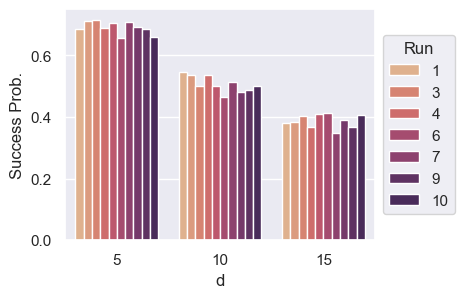

In [38]:
# Plot.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(data=data, x='d', y='Success Prob.', hue='run', palette='flare', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Run')

<Axes: xlabel='run', ylabel='Success Prob.'>

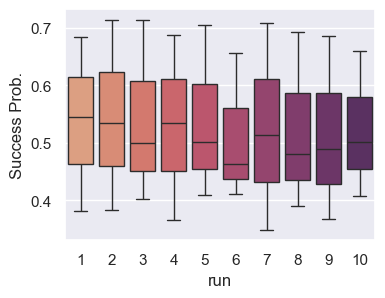

In [37]:
# Plot.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.boxplot(data=data, x='run', y='Success Prob.', palette='flare', ax=ax)